In [1]:
%matplotlib inline

In [2]:
import argparse
import collections
import datetime
import os
import sqlite3
import sys

import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from importlib import reload
import parse_db
reload(parse_db);

In [4]:
conn = sqlite3.connect(os.path.expanduser('~/Dropbox/bowling/Backup.db'))
conn.row_factory = sqlite3.Row 

In [5]:
parse_db.process_db(conn)

First Ball Average: 8.532608695652174
You've bowled 920 frames
---
Pin Leaves
Pin	1	2
1	13.37%	2.83%
2	16.96%	3.26%
3	14.78%	4.13%
4	16.85%	4.57%
5	13.70%	2.83%
6	18.80%	4.89%
7	14.02%	5.87%
8	7.50%	2.17%
9	8.59%	2.39%
10	22.17%	8.59%
---
Strikes: 299 / 920 => 32.500000%
Spares: 344 / 920 => 37.391304%
Opens: 277 / 920 => 30.108696%
---
Splits: 112 / 621 => 18.035427%
Split-Conversion: 18 / 112 => 16.071429%
---
Non-Splits: 509 / 621 => 81.964573%
Non-Split-Conversion: 326 / 509 => 64.047151%
---
Single Pin Leaves: 235 / 509 => 0.46168958742632615
Single Pin Conversion: 161 / 235 =>  0.6851063829787234
For pin 10: 36 / 60 => 60.0%
For pin 6: 32 / 45 => 71.1%
For pin 7: 15 / 27 => 55.6%
For pin 3: 16 / 24 => 66.7%
For pin 4: 22 / 28 => 78.6%
For pin 9: 11 / 14 => 78.6%
For pin 5: 20 / 23 => 87.0%
For pin 2: 5 / 8 => 62.5%
For pin 8: 3 / 5 => 60.0%
For pin 1: 1 / 1 => 100.0%
If single pin conversion was 100%, your average would increase by: 7.667533081285445


In [6]:
figsize=(15, 7)

In [7]:
def put_legend_on_side(ax):
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [8]:
# ID 	Date 	Place 	Games 	Score 	EventName 	BallID 	Comment
rows = conn.execute("select * from T_Event").fetchall()
events = pd.DataFrame(rows, columns=rows[0].keys())

In [9]:
event_to_date = {}
for row in events.itertuples():
    event_to_date[row.ID] = datetime.datetime.strptime(str(row.Date), '%Y%m%d')

In [10]:
rows = list(conn.execute("""select * from T_Event"""))
df = pd.DataFrame(rows, columns=rows[0].keys())
df['EventName'].str.strip().unique()

array(['BIB League', 'Pepsi Match Play', 'Low ball', 'Practice'],
      dtype=object)

In [11]:
# ['ID', 'EventID', 'Game', 'Score']
query = """
select S.*
from T_Score S
inner join T_Event E on E.ID = S.EventID
where (trim(lower(E.EventName)) != 'low ball')"""
score_rows = conn.execute(query).fetchall()
totals = pd.DataFrame(score_rows, columns=score_rows[0].keys())

In [12]:
totals['Date'] = totals['EventID'].apply(lambda v: event_to_date[v])

In [13]:
def get_ticks(df, reset):
    if reset:
        df = df.reset_index(drop=True)
    dates = df.reset_index().groupby(pd.Grouper(key='Date', freq='MS'))['index'].min().reset_index()
    ticks = []
    for row in dates.itertuples():
        ticks.append((row.index, row.Date.strftime('%b-%y')))
    return zip(*ticks)

def set_ticks(ax, df, reset=False):
    ticks, labels = get_ticks(df, reset)
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)

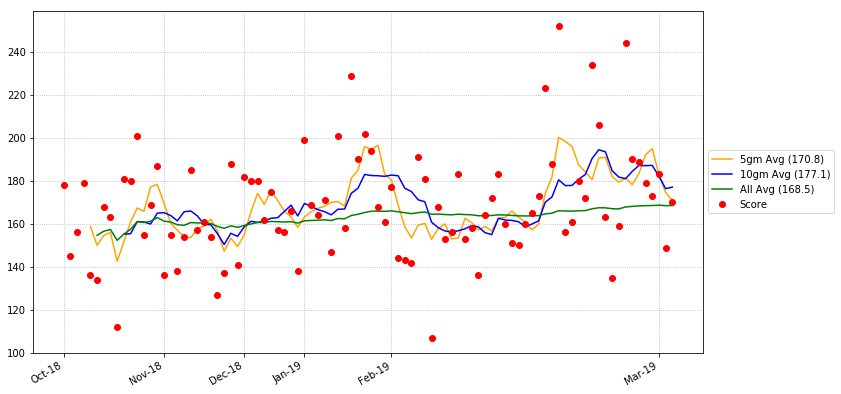

In [14]:
# TODO: color the dots different if its leage vs practice
fig, ax = plt.subplots(figsize=figsize)
scores = totals['Score']
s = scores.rolling(5).mean()
last = s.iloc[-1]
s.plot(ax=ax, label=f'5gm Avg ({last:0.1f})', color="orange")
s = scores.rolling(10).mean()
last = s.iloc[-1]
s.plot(ax=ax, label=f'10gm Avg ({last:0.1f})', color="blue")
s = scores.expanding(6).mean()
last = s.iloc[-1]
s.plot(ax=ax, label=f'All Avg ({last:0.1f})', color="green")
scores.plot(ax=ax, marker='o', linestyle='', color="red");
set_ticks(ax, totals)
fig.autofmt_xdate()
ax.grid(linestyle='dotted')
put_legend_on_side(ax);

In [15]:
# ['ID', 'Game', 'Frame', 'T1', 'T2', 'Foul1', 'Foul2', 'Split', 'Renzoku', 'Pin']
game_rows = conn.execute("""
select G.*
from T_Games G
inner join T_Event E
on G.ID = E.ID
where (trim(lower(E.EventName)) != 'low ball')""").fetchall()
frames_df = pd.DataFrame(game_rows, columns=game_rows[0].keys())
frames_df = frames_df[frames_df['Frame'] <= 10]

pin_leaves = []
for row in game_rows:
    if row['Frame'] > 10:
        continue
    pins = row['Pin']
    pin_leaves.append(parse_db.parse_pins(pins))
n = len(pin_leaves)

In [16]:
frames_df['Date'] = frames_df['ID'].apply(lambda v: event_to_date[v])

In [17]:
frames_df.head()

,ID,Game,Frame,T1,T2,Foul1,Foul2,Split,Renzoku,Pin,Date
0,1,1,1,8,1,0,0,1,0,102000,2018-10-01
1,1,1,2,7,0,0,0,0,0,20020002,2018-10-01
2,1,1,3,10,0,0,0,0,1,0,2018-10-01
3,1,1,4,10,0,0,0,0,2,0,2018-10-01
4,1,1,5,10,0,0,0,1,3,0,2018-10-01


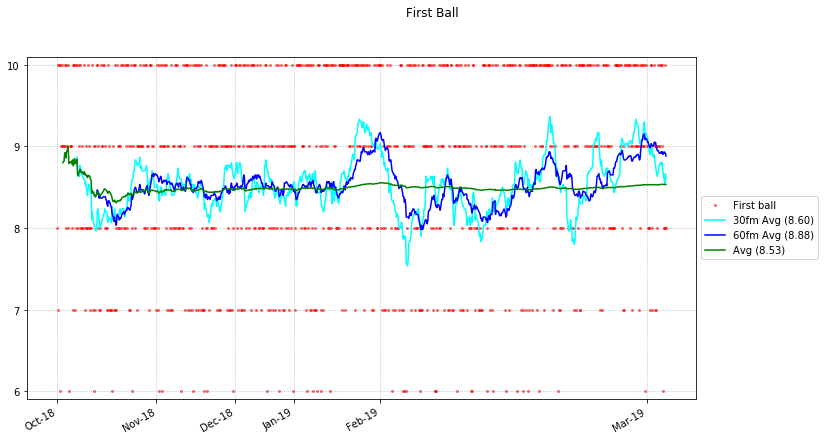

In [18]:
fig, ax = plt.subplots(figsize=figsize)
scores = frames_df['T1']
scores.plot(ax=ax, marker='o', linestyle='', markersize=2, color="red", alpha=.5, label='First ball');
s = scores.rolling(30).mean()
last = s.iloc[-1]
s.plot(ax=ax, label=f'30fm Avg ({last:0.2f})', color="cyan")
s = scores.rolling(60).mean()
last = s.iloc[-1]
s.plot(ax=ax, label=f'60fm Avg ({last:0.2f})', color="blue")
s = scores.expanding(10).mean()
last = s.iloc[-1]
s.plot(ax=ax, label=f'Avg ({last:0.2f})', color="green")
fig.suptitle('First Ball')
ax.grid(linestyle='dotted')
ax.set_ylim(5.9, 10.1)
ax.set_yticks((6, 7, 8, 9, 10))
set_ticks(ax, frames_df)
fig.autofmt_xdate()
put_legend_on_side(ax)

In [19]:
# Picked some colors from:
# http://colorbrewer2.org/#type=sequential&scheme=Blues&n=9
linestyles = (
    {'color': '#c6dbef', 'alpha': 0.6},
    {'color': '#4292c6', 'alpha': 0.8},
    {'color': '#08306b'},
)
def plot_rolling_successes(series, title, windows=(10, 30, 60), linestyles=linestyles):
    fig, ax = plt.subplots(figsize=figsize)
    for window, ls in zip(windows, linestyles):
        mean = series.rolling(window).mean()
        last = mean.iloc[-1]
        mean.plot(ax=ax, label=f'Last {window} ({last:.0%})', **ls)
    fig.suptitle(title);
    ax.grid(linestyle='dotted')
    ax.set_ylabel('Success')
    ax.set_xlabel('Attempts')
    put_legend_on_side(ax)
    return fig, ax

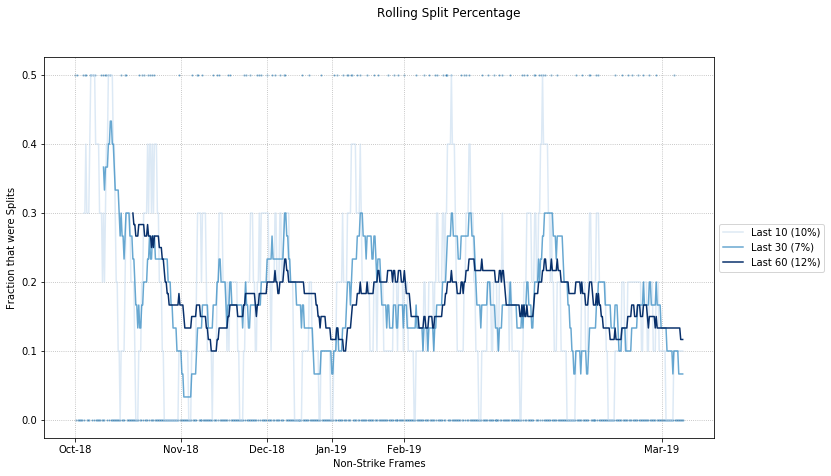

In [20]:
# Split percentage is fraction of NON-STRIKES that were splits.
is_not_strike = frames_df[frames_df['T1'] < 10]
is_split = (is_not_strike['Split'] == 1).astype(int).reset_index(drop=True)
fig, ax = plot_rolling_successes(is_split, 'Rolling Split Percentage')
ax.scatter(is_split.index, is_split*.5, marker='.', alpha=.5, s=5)
ax.set_ylabel('Fraction that were Splits')
ax.set_xlabel('Non-Strike Frames');
set_ticks(ax, is_not_strike, reset=True)

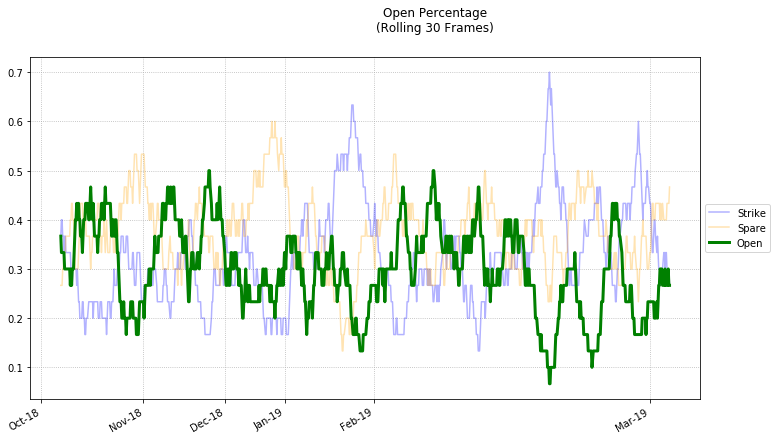

In [21]:
# TODO: break out the spare percentage between splits and non-split spares
#       because an increase in spare percentage could just come from leaving
#       less splits and/or from making more non-split spares and it would be
#       nice to know which
is_strike = (frames_df['T1'] == 10).astype(int)
rolling_strike = is_strike.rolling(30).mean()
is_open = (frames_df['T1'] + frames_df['T2'] < 10).astype(int)
rolling_open = is_open.rolling(30).mean()
rolling_spare = 1 - rolling_strike - rolling_open

fig, ax = plt.subplots(figsize=figsize)
rolling_strike.plot(color="blue", alpha=.3, label='Strike')
rolling_spare.plot(color="orange", alpha=.3, label='Spare')
rolling_open.plot(color="green", label='Open', linewidth=3);
fig.suptitle('Open Percentage\n(Rolling 30 Frames)')

ax.grid(linestyle='dotted')
set_ticks(ax, frames_df)
fig.autofmt_xdate()
put_legend_on_side(ax)

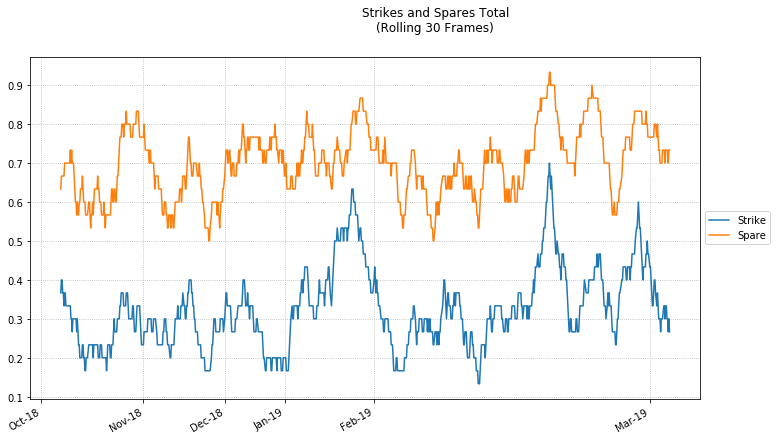

In [22]:
# this is the same data as the above plot, just stacked.
fig, ax = plt.subplots(figsize=figsize)
pd.DataFrame({'Strike': rolling_strike, 'Spare': rolling_spare}).dropna().plot(
    stacked=True, legend=False, ax=ax)
ax.figure.suptitle('Strikes and Spares Total\n(Rolling 30 Frames)');

ax.grid(linestyle='dotted')
set_ticks(ax, frames_df)
fig.autofmt_xdate()
put_legend_on_side(ax)

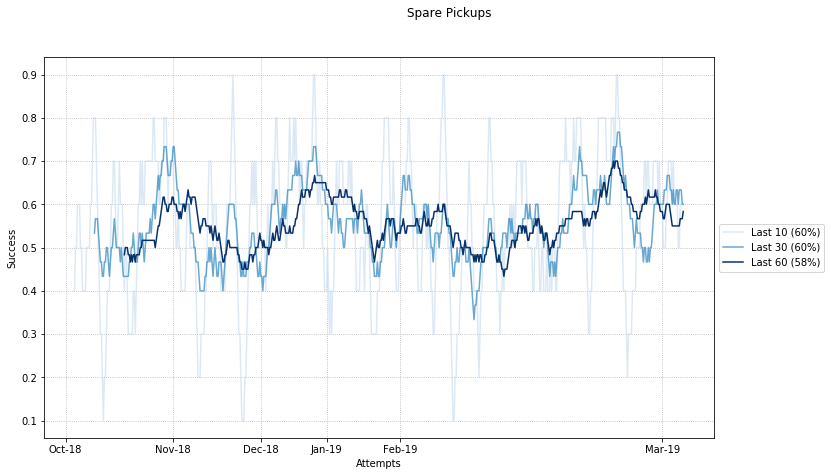

In [23]:
spare_leaves = frames_df[frames_df['T1'] < 10]
spare_pickups = (spare_leaves['T1'] + spare_leaves['T2'] == 10).astype(int).reset_index(drop=True)
fig, ax = plot_rolling_successes(spare_pickups, 'Spare Pickups');
set_ticks(ax, spare_leaves, reset=True)

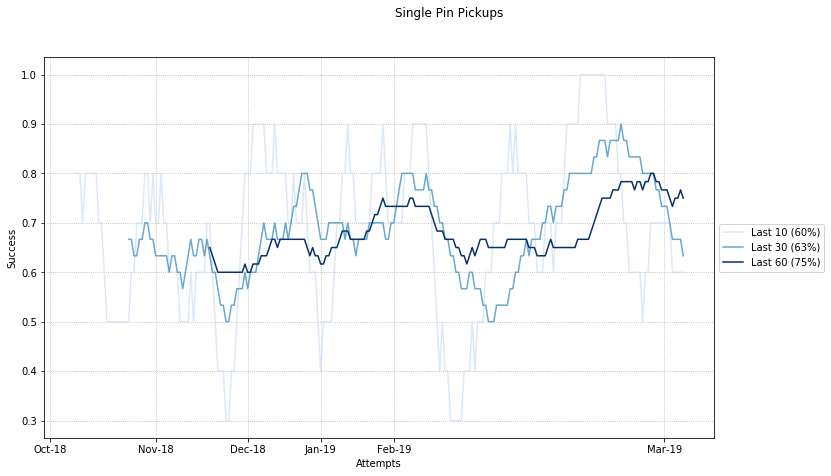

In [24]:
single_pin_leaves = frames_df[frames_df['T1'] == 9]
single_pin_spares = (single_pin_leaves['T2'] == 1).astype(int)
single_pin_spares = single_pin_spares.reset_index(drop=True)

fig, ax = plot_rolling_successes(single_pin_spares, 'Single Pin Pickups');
set_ticks(ax, single_pin_leaves, reset=True)

In [25]:
def get_single_pin_leaves(pin_leaves, pin):
    for i, leave in enumerate(pin_leaves):
        if leave['first_ball'] == {pin}:
            yield i, leave

def get_makes(pin_leaves, pin):
    for i, leave in get_single_pin_leaves(pin_leaves, pin):
        if len(leave['second_ball']) == 0:
            yield i
            
def get_misses(pin_leaves, pin):
    for i, leave in get_single_pin_leaves(pin_leaves, pin):
        if len(leave['second_ball']) == 1:
            yield i

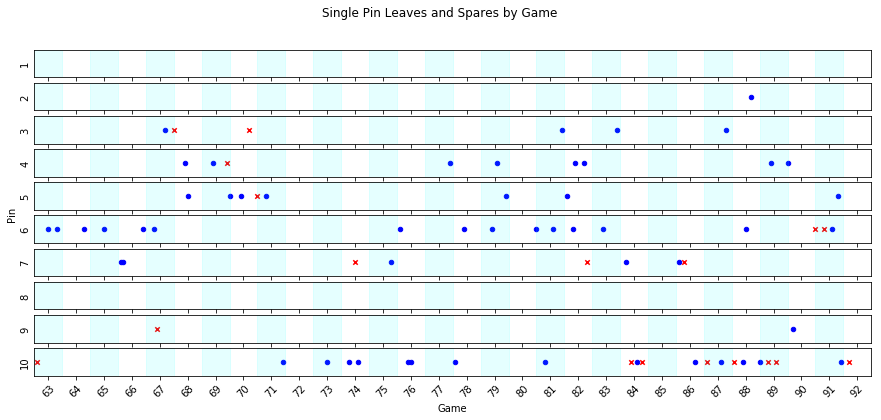

In [26]:
def plot_single_pin_leaves(pin_leaves, n_games=30):
    n_frames = n_games * 10
    end_frame = len(pin_leaves)
    start_frame = end_frame - n_frames
    pin_leaves = pin_leaves[-n_frames:]
    #x = range(len(pin_leaves))
    fig, axs = plt.subplots(nrows=10, ncols=1, sharex=True, figsize=(15, 6))
    for pin, ax in enumerate(axs, 1):
        makes = list(get_makes(pin_leaves, pin))
        ax.scatter(makes, [0]*len(makes), marker='o', color='b', s=20)
        misses = list(get_misses(pin_leaves, pin))
        ax.scatter(misses, [0]*len(misses), marker='x', color='r', s=20)
        ax.set_yticks([])
        ax.set_ylabel(pin)
        ax.set_xlim(0, n_frames)
        # color every other game
        for i in range(0, n_frames, 20):
            ax.axvspan(i, i+10, color='cyan', alpha=.1)
    # put a tick mark in the middle
    ax.set_xticks(range(5, n_frames+15, 10))
    ax.set_xticklabels(frames_to_games(start_frame, end_frame));
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    ax.set_xlim(0, n_frames)
    ax.set_xlabel('Game')
    fig.text(0.1, 0.5, 'Pin', va='center', rotation='vertical')
    fig.suptitle('Single Pin Leaves and Spares by Game');
    
def frames_to_games(start_frame, end_frame):
    return range(start_frame // 10 + 1, end_frame // 10 + 1)

    
plot_single_pin_leaves(pin_leaves)

In [27]:
#rows = conn.execute('select Game, Frame, T1, T2 from T_Games').fetchall()

In [28]:
def score(a, b, c):
    if a['T1'] == 10:
        if b['T1'] == 10:
            assert a['Game'] == b['Game'] == c['Game']
            return 10 + 10 + c['T1']
        else:
            assert a['Game'] == b['Game'], (a['Game'], b['Game'])
            return 10 + b['T1'] + b['T2']
    elif a['T1'] + a['T2'] == 10:
        assert a['Game'] == b['Game'], (a['Game'], b['Game'])
        return 10 + b['T1']
    else:
        return a['T1'] + a['T2']

In [29]:
import itertools

In [30]:
frames = [[] for _ in range(10)]
for a, b, c in itertools.zip_longest(game_rows, game_rows[1:], game_rows[2:]):
    if a['Frame'] > 10:
        continue
    frames[a['Frame'] - 1].append(score(a, b, c))

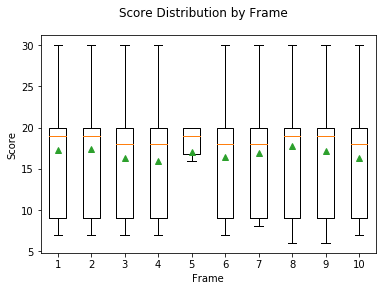

In [31]:
plt.boxplot(frames, sym='', showmeans=True);
plt.suptitle('Score Distribution by Frame');
plt.xlabel('Frame')
plt.ylabel('Score');

In [32]:
import numpy as np

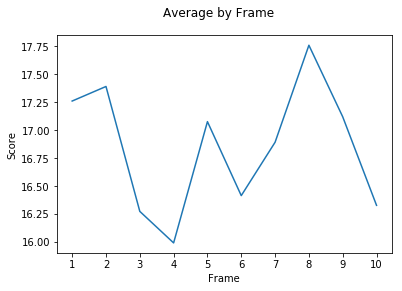

In [33]:
plt.plot(np.mean(frames, axis=1))
plt.xticks(range(10), labels=range(1, 11));
plt.xlabel('Frame')
plt.suptitle('Average by Frame');
plt.ylabel('Score');

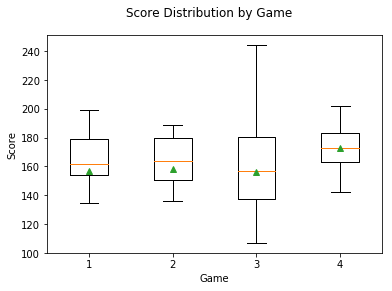

In [34]:
score_by_game = collections.defaultdict(list)
rows = conn.execute('select * from T_Score').fetchall()
for row in rows:
    score_by_game[row['Game']-1].append(row['Score'])
scores = [score_by_game[k] for k in sorted(score_by_game.keys())]
plt.boxplot(scores, sym='', showmeans=True);
plt.suptitle('Score Distribution by Game')
plt.xlabel('Game');
plt.ylabel('Score');

In [35]:
pin_to_row = {1: 1, 2: 2, 3: 2, 4: 3, 5: 3, 6: 3, 7: 4, 8: 4, 9: 4, 10: 4}
throw_hit_head_pin = []
for leave in pin_leaves:
    first_ball = leave['first_ball']
    throw_hit_head_pin.append('1' not in first_ball)
    if not first_ball:
        continue
    second_ball = leave['second_ball']
    if not second_ball:
        throw_hit_head_pin.append(True)
        continue
    first_rows = collections.Counter(pin_to_row[p] for p in first_ball)
    second_rows = collections.Counter(pin_to_row[p] for p in second_ball)
    min_row = min(first_rows)
    if second_rows.get(min_row, 0) < first_rows[min_row]:
        throw_hit_head_pin.append(True)
    else:
        throw_hit_head_pin.append(False)

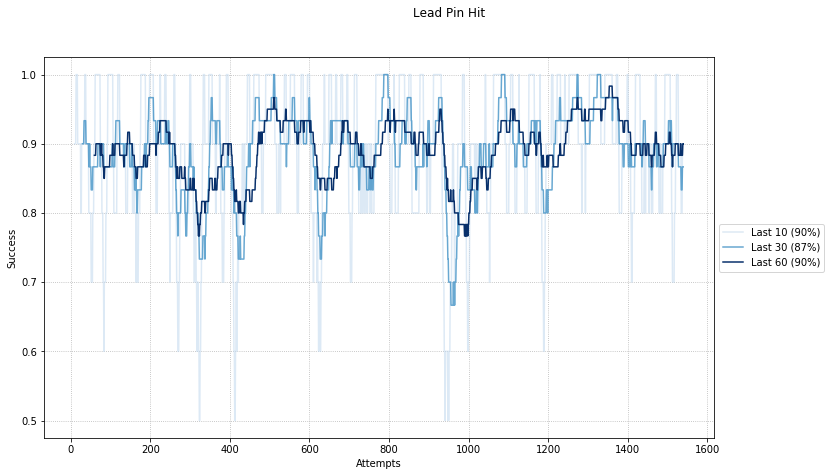

In [36]:
hit_lead_pin = pd.Series(throw_hit_head_pin)
plot_rolling_successes(hit_lead_pin, "Lead Pin Hit");